In [1]:
from brownpy.gpu_sim import Universe
import brownpy.topology as Top
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
plt.style.use('dark_background')

In [5]:
dt = int(1E3) #fs (1ps) - time steps
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

# Geometry
L = 1E4 # A (1um) - periodic size
h = 40E1 # A (40nm) - channel height
N= 4*1024

In [3]:
# top = Top.Periodic(L=L)
l= 100E9*1E-15*dt # 100GHz
top = Top.InfiniteSlitAbsorbing(L=L, h=h, l=l)
u = Universe(N=N, top=top, D=D, dt=dt,
             output_path='slit')

slit.hdf5 already exists, change output filename for slit_2.hdf5


(-300.0, 300.0)

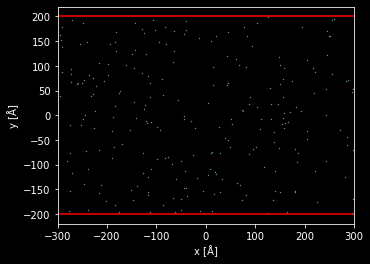

In [4]:
fig, ax = u.plot_pos()
ax.set_xlim(-300,300)


In [5]:
u.run(1_000_000, freq_dumps=100);

100%|██████████| 1000000/1000000 [00:03<00:00, 256370.19it/s, total=1 µs]

With 4096 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 12.1 fs
Engine: 450 ps
Transfert to RAM: 186 ps
Total: 636 ps
------------------------------------------
CPU time per step and per particles:
Total: 954 ps
------------------------------------------
For a timestep of 1 ps
To simulate the trajectory of 1 particle during 1 s, we need 954  s


In [6]:
trajectory = u[0]['trajectory']

Reading trajectory ...
... Done
Reading 0 ...
... Done


(-2640.147705078125, -1880.8123779296875)

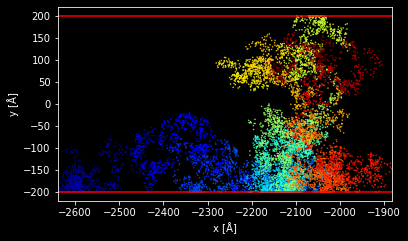

In [13]:
fig, ax = plt.subplots()
top.plot(ax)
i_particle = 6
ax.scatter(trajectory[i_particle,0,:], trajectory[i_particle,1,:], 
           c=np.arange(trajectory.shape[2]), marker='.', cmap='jet', s=1)
ax.set_xlim(np.min(trajectory[i_particle,0,:]), np.max(trajectory[i_particle,0,:]) )       

In [19]:
u.run(1_000_000_000);

100%|██████████| 1000000000/1000000000 [29:18<00:00, 568747.44it/s, total=1 ms]

With 4096 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 9.15 fs
Engine: 421 ps
Transfert to RAM: 2.12 ps
Total: 423 ps
------------------------------------------
CPU time per step and per particles:
Total: 429 ps
------------------------------------------
For a timestep of 1 ps
To simulate the trajectory of 1 particle during 1 s, we need 429  s


In [2]:
import h5py
f = h5py.File('slit_2.hdf5', "r")
absorbed = f['run']['1']['regions']['absorbed'][...]
f.close()

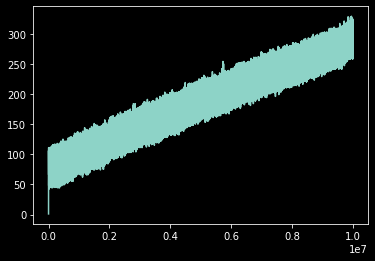

In [3]:
plt.plot(absorbed[::100])

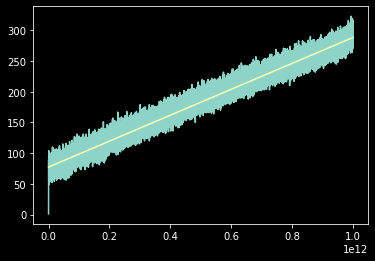

In [6]:
x = np.arange(len(absorbed[::100]), dtype=np.int64)*dt*100
y = absorbed[::100]
p = np.polyfit(x,y,1)
plt.plot(x[::100],y[::100])
plt.plot(x[::100],(p[0]*x+p[1])[::100])

In [14]:
from numba import jit
@jit(nopython=True)
def correct(absorbed, p, dt):
    N = len(absorbed)
    out = np.zeros(N, dtype=np.int16)
    for i in range(len(absorbed)):
        out[i] = absorbed[i] - (p[0]*i*dt+p[1])
    return out

In [15]:
absorbed_corrected = correct(absorbed, p, dt)

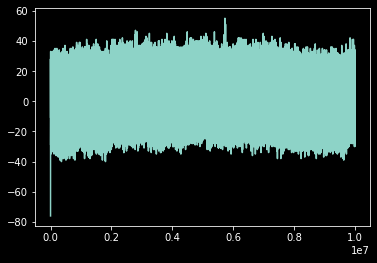

In [16]:
plt.plot(absorbed_corrected[::100])

In [17]:
from scipy.signal import welch
from importlib import reload
from brownpy import stats
reload(stats)

<module 'brownpy.stats' from 'c:\\users\\monet\\documents\\job\\2021_postdoc\\code\\brownpy\\brownpy\\stats.py'>

In [18]:
# psd, freqs = stats.PSD_gpu(absorded, dt*1E-15)
psd_bin, freqs_bin = stats.PSD_gpu_binned(absorbed[::100], 100*dt*1E-15, bins=100)
# psd_bin3, freqs_bin3 = stats.PSD_gpu_binned(absorbed[::100], 100*dt*1E-15, bins=100)
# psd_bin2, freqs_bin2 = stats.PSD_gpu_binned(absorbed_corrected[::10], 10*dt*1E-15, bins=100)

In [20]:
psd_bin2 = 0
N_steps = len(absorbed_corrected)
N_chunk = 10
chunk_size = N_steps//N_chunk
for i in range(N_chunk):
    psd_bin2_sub, freqs_bin2 = stats.PSD_gpu_binned(absorbed_corrected[i*chunk_size:(i+1)*chunk_size], dt*1E-15, bins=500)
    psd_bin2 += psd_bin2_sub
psd_bin2/=10

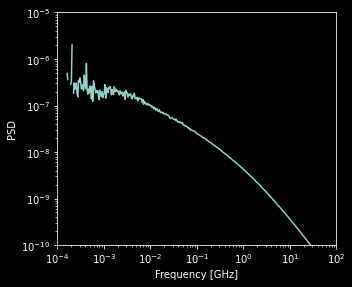

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
# ax.loglog(freqs*1E9, psd)
# ax.loglog(freqs_bin*1E-9, psd_bin)
ax.loglog(freqs_bin2*1E-9, psd_bin2)
# ax.loglog(freqs_bin3*1E-9, psd_bin3)
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim(1E-4, 1E2)
ax.set_ylim(1E-10, 1E-5)
ax.set_ylabel('PSD')
ax.set_aspect('equal')

In [26]:
np.diff(np.log(freqs_bin2))[0]

0.03545506712678659

In [22]:
from scipy.signal import savgol_filter

In [40]:
first_index = (np.arange(len(psd_bin2))[(np.isnan(np.log(psd_bin2)))])[-1]+1
x = freqs_bin2[first_index:]
y = psd_bin2[first_index:]

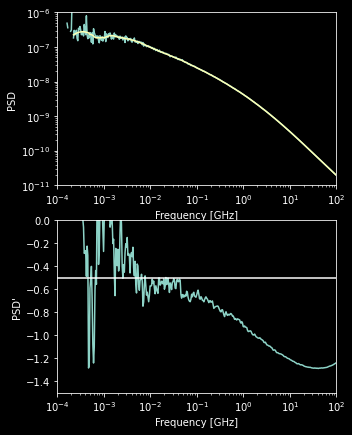

In [62]:
delta = np.diff(np.log(x))[0]
y_smooth = np.exp(savgol_filter(np.log(y),31,2,delta=delta))

fig, axes = plt.subplots(2, figsize=(5,7))
# ax.loglog(freqs*1E9, psd)
# ax.loglog(freqs_bin*1E-9, psd_bin)
ax = axes[0]
ax.loglog(freqs_bin2*1E-9, psd_bin2)
ax.loglog(x*1E-9, y_smooth)
# ax.loglog(freqs_bin3*1E-9, psd_bin3)
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim(1E-4, 1E2)
ax.set_ylim(1E-11, 1E-6)
ax.set_ylabel('PSD')
# ax.set_aspect('equal')

ax = axes[1]
ax.semilogx(x*1E-9, np.gradient(np.log(y_smooth))/np.gradient(np.log(x)))
# ax.loglog(freqs_bin3*1E-9, psd_bin3)
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim(1E-4, 1E2)
ax.set_ylim(-1.5, 0)
ax.set_ylabel('PSD\'')
ax.axhline(-0.5)
# ax.set_aspect('equal')

In [72]:
# Estimation of the number of particles in simulation of figure 1:
from scipy.constants import N_A
H_n = 20E-9
V = (4*np.pi/3)*H_n**3 # Reservoir volume
cs = 15 * 1E-3 *1E3 #15mM = 15 mmol/L of monovalent
print(f'Number of particles in reservoirs: {V*cs*N_A:.0f}')


Number of particles in reservoirs: 303


In [73]:
# If we do the same for figure 2:
# Sphere:
Rc = 20E-9
V = (4*np.pi/3)*Rc**3
cs = 15 * 1E-3 *1E3 #15mM = 15 mmol/L of monovalent
print(f'Number of particles in sphere: {V*cs*N_A:.0f}')

Number of particles in sphere: 303
